#### Introduction: <br>
Data is taken from https://www.kaggle.com/lava18/google-play-store-apps


From this google playstore dataset, I made explanatory data analysis and found factors that influence ratings in Google playstore. Also, I built a simple machine learning model to predict the rating of applications

**Description**: <br>
<br>
**data** contains details of the applications on Google Play. There are 13 features that descibe a given app: <br>
- Category: Category the app belongs to
- Rating: Overall user rating of the app (as when scraped)
- Reviews: Number of user reviews for the app (as when scraped)
- Size: Size of the app (as when scraped)
- Installs: Number of user downloads/installs for the app (as when scraped)
- Type: Paid or Free
- Price: Price of the app (as when scraped)
- Content Rating: Age group the app is targeted at - Children / Mature 21+ / Adult
- Genres: An app can belong to multiple genres (apart from its main category). For eg, a musical family game will belong to Music, Game, Family genres.
- Last Updated: Date when the app was last updated on Play Store (as when scraped)
- Current Ver: Current version of the app available on Play Store (as when scraped)
- Android Ver: Min required Android version (as when scraped)

**reviews** contains the first 'most relevant' 100 reviews for each app. Each review text/comment has been pre-processed and attributed with 3 new features - Sentiment, Sentiment Polarity and Sentiment Subjectivity: <br>
- App: Name of app
- Translated_Review: User review (Preprocessed and translated to English)
- Sentiment: Positive/Negative/Neutral (Preprocessed)
- Sentiment_Polarity: Sentiment polarity score
- Sentiment_Subjectivity: Sentiment subjectivity score

In [1]:
# import libraries 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set(style="ticks", color_codes=True)
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.express as px
import scipy
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multitest import multipletests
from itertools import combinations
import plotly.figure_factory as ff
import plotly
import cufflinks as cf
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error
from sklearn.decomposition import PCA
from  sklearn.ensemble import RandomForestRegressor
import category_encoders as ce
%matplotlib inline


In [2]:
data = pd.read_csv('E:/python\Machine_learning/Kaggle_competitions/google-play-store-apps/googleplaystore.csv') 

In [3]:
reviews = pd.read_csv('E:/python\Machine_learning/Kaggle_competitions/google-play-store-apps/googleplaystore_user_reviews.csv')

#### Data preprocessing

In [4]:
print(f'There are {data.isnull().sum().sum()} missing values in dataset')


There are 1487 missing values in dataset


- Let's see some statistics on missing data by categories:

In [5]:

sorted_values = data.isnull().sum().sort_values(ascending=False)
missed_values = sorted_values[sorted_values>0]
share = missed_values/ (data.shape[0] * data.shape[1])
pd.concat([missed_values, share], axis=1, keys=['Missed values', 'Share in dataset'])

,Missed values,Share in dataset
Rating,1474,0.010459
Current Ver,8,0.000057
Android Ver,3,0.000021
Content Rating,1,0.000007
Type,1,0.000007


- We'd lose very little information if drop rows with missed values. Let's do it:

In [6]:
data.dropna(axis=0, inplace = True)
print(f'We have lost {10841 - data.shape[0]} rows or {round((1 - data.shape[0]/10841), 4)*100}% of information as maximum')

We have lost 1481 rows or 13.66% of information as maximum


In [7]:
def clean_data(data):
    '''Removes '+' and ',', converts type to int in installs,
    Removes letters, converts to megabytes if kilobytes, than converts  type to float if possible in Size,
    Removes $, than converts type to float in Price '''
    data.Installs = data.Installs.apply(lambda x: x.replace('+', '') if '+' in str(x) else x)
    data.Installs = data.Installs.apply(lambda x: x.replace(',', '') if ',' in str(x) else x)
    data.Installs = data.Installs.apply(lambda x: x.replace(' ', '') if ' ' in str(x) else x)
    data.Installs = data.Installs.apply(lambda x: int(x))
    data.Reviews = data.Reviews.apply(lambda x: int(x))
    
    data.Size = data.Size.apply(lambda x: x.replace('M', '') if 'M' in str(x) else x)
    data.Size = data.Size.apply(lambda x: float(str(x).replace('k', '')) /1024 if 'k' in str(x) else x)
    data.Size = data.Size.apply(lambda x: str(x).replace('Varies with device', 'Nan') if 'Varies with device' in str(x) else x)
    data.Size = data.Size.apply(lambda x: float(x))
    data.Size.fillna(data.Size.mean())
    
    data.Price = data.Price.apply(lambda x: str(x).replace('$', '') if '$' in str(x) else int(x))
    data.Price = data.Price.apply(lambda x: float(x))
    return data

clean_data(data)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10834,FR Calculator,FAMILY,4.0,7,2.6,500,Free,0.0,Everyone,Education,"June 18, 2017",1.0.0,4.1 and up
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53.0,5000,Free,0.0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6,100,Free,0.0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,NaN,1000,Free,0.0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


In [8]:
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(data[['Size']])
data['Size'] = imr.transform(data[['Size']]).ravel()

#### Explore features

###### Rating

In [9]:
pd.DataFrame(data.Rating.describe())

,Rating
count,9360.000000
mean,4.191838
std,0.515263
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,5.000000


[]

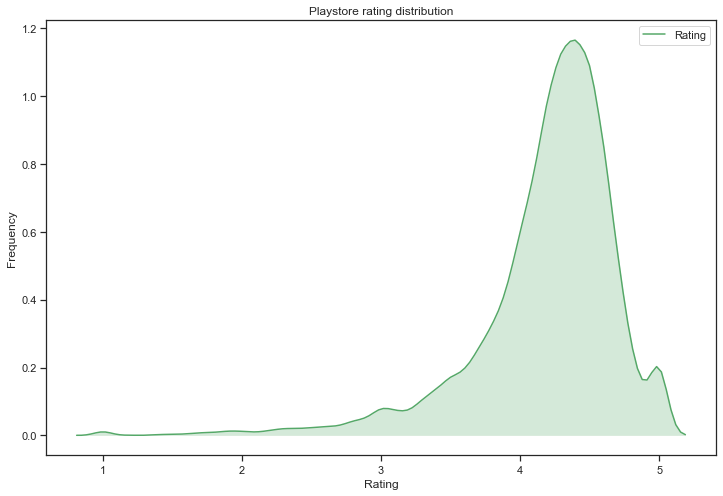

In [10]:
plt.figure(figsize=(12,8))
sns.kdeplot(data.Rating, color='g', shade=True)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Playstore rating distribution')
plt.plot()

- users tend to grade apps high

It's may be useful to find the highest rated apps in the dataset. To make this reasonable, it's better to look at apps with large number of reviews, say, 100000 and more

In [11]:
top_app = pd.pivot_table(data[data.Reviews >100000], values='Rating', index=['App', 'Category'], aggfunc= np.mean).sort_values('Rating', ascending=False)
print('The highest rated apps:')
top_app.rename(columns={'Rating': 'Average rating'})[:10]

The highest rated apps:


,,Average rating
App,Category,
JW Library,BOOKS_AND_REFERENCE,4.9
Six Pack in 30 Days - Abs Workout,HEALTH_AND_FITNESS,4.9
Tickets + PDA 2018 Exam,AUTO_AND_VEHICLES,4.9
Period Tracker,MEDICAL,4.9
"Learn Japanese, Korean, Chinese Offline & Free",EDUCATION,4.9
"DU Recorder – Screen Recorder, Video Editor, Live",VIDEO_PLAYERS,4.8
Amino: Communities and Chats,SOCIAL,4.8
Video Player All Format,VIDEO_PLAYERS,4.8
Lose Weight in 30 Days,HEALTH_AND_FITNESS,4.8


- Interesting, that there is no apps with peak rating. Indeed, it is difficult to please everybody 
- If you want to make popular and highly rated app, you should choose categories with large audience

###### Categories

There are 33 categories in dataset(ordered by popularity):


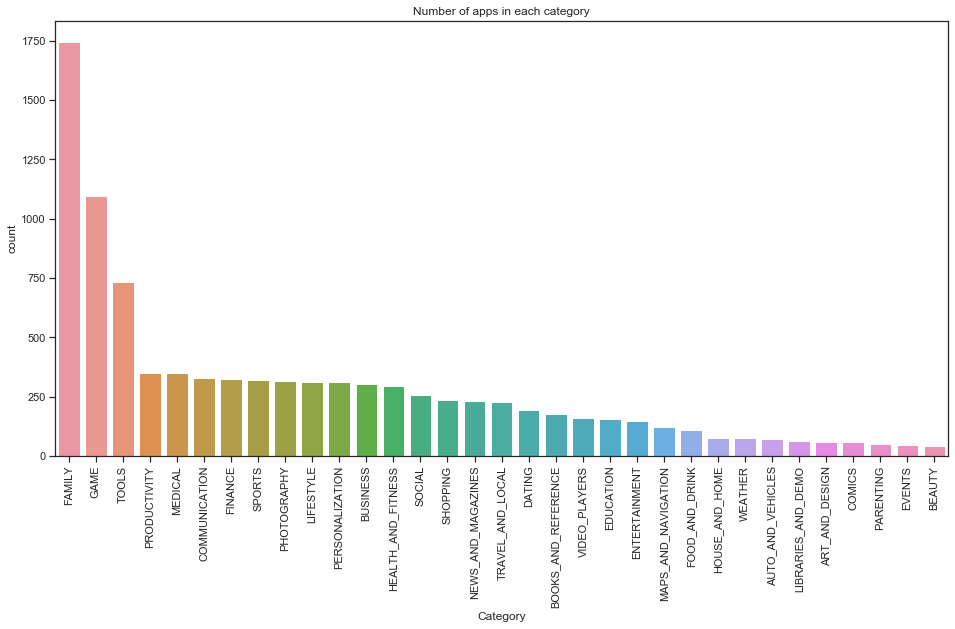

In [12]:
print(f'There are {data.Category.nunique()} categories in dataset(ordered by popularity):')
fig, ax = plt.subplots(figsize=(16,8))
cats = sns.countplot(x = data.Category, order = list(data.Category.value_counts().index))
cats.set_xticklabels(list(data.Category.value_counts().index), rotation=90)
plt.title('Number of apps in each category')
plt.show()

- Family and Games apps have the highest market prevalence
- Interesting, that Tools and Medical apps are also in the top

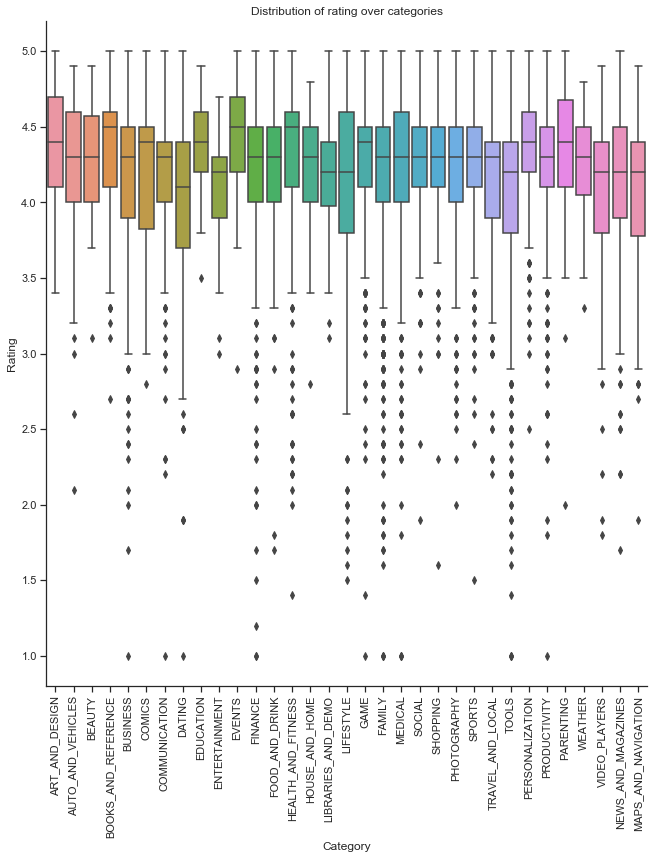

In [13]:
boxplot = sns.catplot(x='Category', y='Rating', data=data, kind='box', height = 10, aspect=1)
boxplot.set_xticklabels(rotation=90)
plt.ylabel('Rating')
plt.title('Distribution of rating over categories')
plt.show()

As we see, average ratings slightly differ over categories. Let's **check whether there are statistically significant differences or not**, performing a one-way ANOVA test.

In [14]:
stats.f_oneway(data.loc[data.Category == 'BUSINESS']['Rating'], 
               data.loc[data.Category == 'FAMILY']['Rating'],
               data.loc[data.Category == 'GAME']['Rating'],
               data.loc[data.Category == 'PERSONALIZATION']['Rating'],
               data.loc[data.Category == 'LIFESTYLE']['Rating'],
               data.loc[data.Category == 'FINANCE']['Rating'],
               data.loc[data.Category == 'EDUCATION']['Rating'],
               data.loc[data.Category == 'MEDICAL']['Rating'],
               data.loc[data.Category == 'TOOLS']['Rating'],
               data.loc[data.Category == 'PRODUCTIVITY']['Rating']
              )


F_onewayResult(statistic=17.413514995458975, pvalue=9.395283681144346e-29)

- AS **F-statistics is much more than 0**, and p-value is an approximately 0, we reject null hypothesis about equality of ratings in all categories
- More than 50% of apps in Health and Fitness as well as Books and Reference categories have a **rating over 4.5**

##### How does app size impact rating?

In [15]:
subset_df = data[data.Size>40]

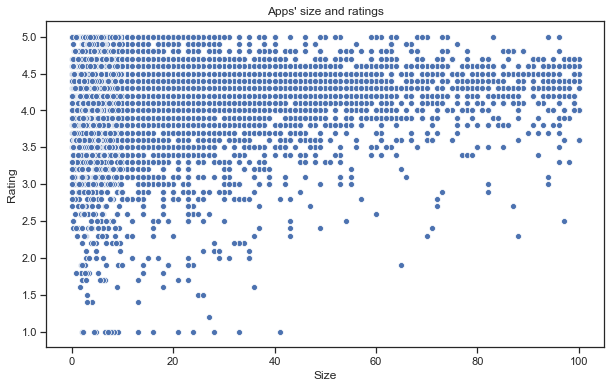

In [16]:
plt.figure(figsize=(10,6))
sns.color_palette("ch:2.5,-.2,dark=.3")
sns.scatterplot(data.Size, data.Rating)
plt.title('Apps\' size and ratings')
plt.show()

- Most **top-rated apps have a size between 2 and about 30 MB** - neither too light or too heavy


#### What about price?

Let's look at top-10 categories

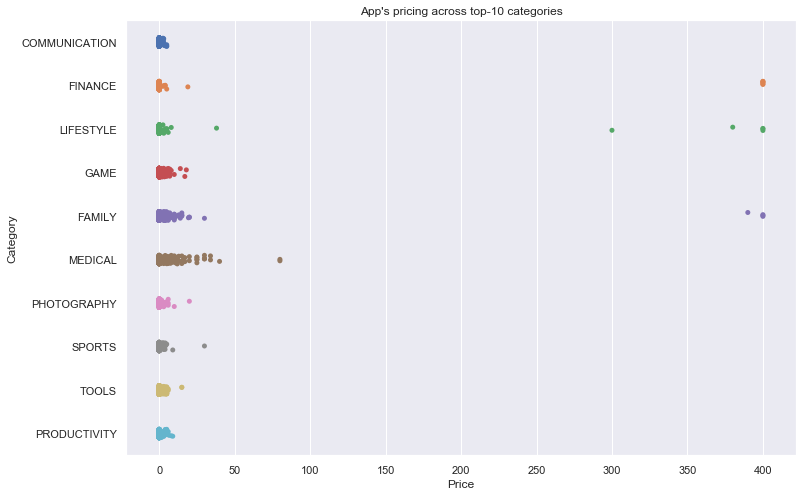

In [17]:
plt.figure(figsize = (12,8))
sns.set_style('darkgrid')
sns.stripplot(y = 'Category', x = 'Price', data=data[data.Category.isin(list(data.Category.value_counts().index[:10]))], jitter=True)
plt.title('App\'s pricing across top-10 categories')
plt.show()

- There are **apps priced at over $200**. Let's briefly examine what are they.

In [18]:
data[['Category', 'App', 'Price']][data.Price > 200].sort_values(by='Price', ascending=False)

,Category,App,Price
4367,LIFESTYLE,I'm Rich - Trump Edition,400.00
4197,FAMILY,most expensive app (H),399.99
4362,LIFESTYLE,💎 I'm rich,399.99
5351,LIFESTYLE,I am rich,399.99
5354,FAMILY,I am Rich Plus,399.99
5356,FINANCE,I Am Rich Premium,399.99
5358,FINANCE,I am Rich!,399.99
5359,FINANCE,I am rich(premium),399.99
5362,FAMILY,I Am Rich Pro,399.99
5364,FINANCE,I am rich (Most expensive app),399.99


- Of course, it's very 'useful' apps like 'I'm reach'<br>
Let's look at prices' distribution without these extremely expensive apps:

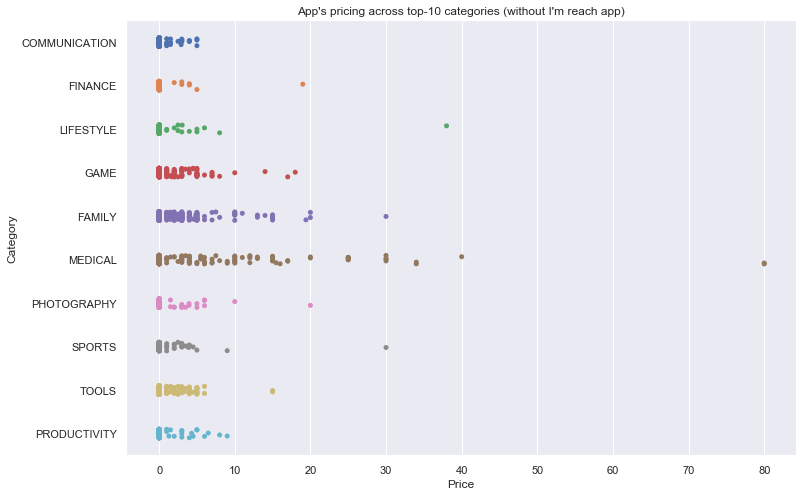

In [19]:
plt.figure(figsize = (12,8))
sns.set_style('darkgrid')
sns.stripplot(y = 'Category', x = 'Price', data=data[(data.Category.isin(list(data.Category.value_counts().index[:10])))&(data.Price < 200)], jitter=True)
plt.title('App\'s pricing across top-10 categories (without I\'m reach app)')
plt.show()

- Clearly, Medical apps are the most expensive with a price of up to 80 USD. And more, now in 2020, this **the most expensive medical app** - Vargo Anesthesia Mega App - costs $99 (I just have googled it). Surprisingly, games cost relatively little: 20 USD and less

#### Free vs Paid apps

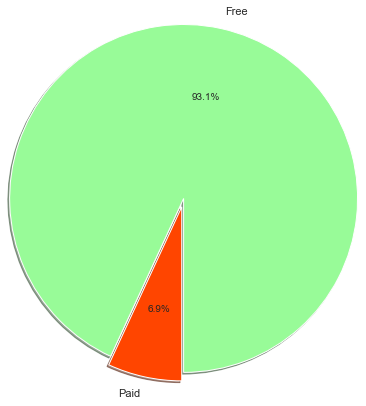

In [20]:
size = data.Type.value_counts()
labels = data.Type.value_counts().index

colors = ['palegreen','orangered']
explode = (0, 0.1)

plt.pie(size, explode, labels, colors, shadow=True, autopct='%1.1f%%', startangle=270, radius=2)
plt.show()

- As expected, the share of Paid apps in Android playstore is relatively small

#### Are paid apps are downloaded as much as free apps?
As number of installs is big, I firstly logarithm number of installs, than plot it

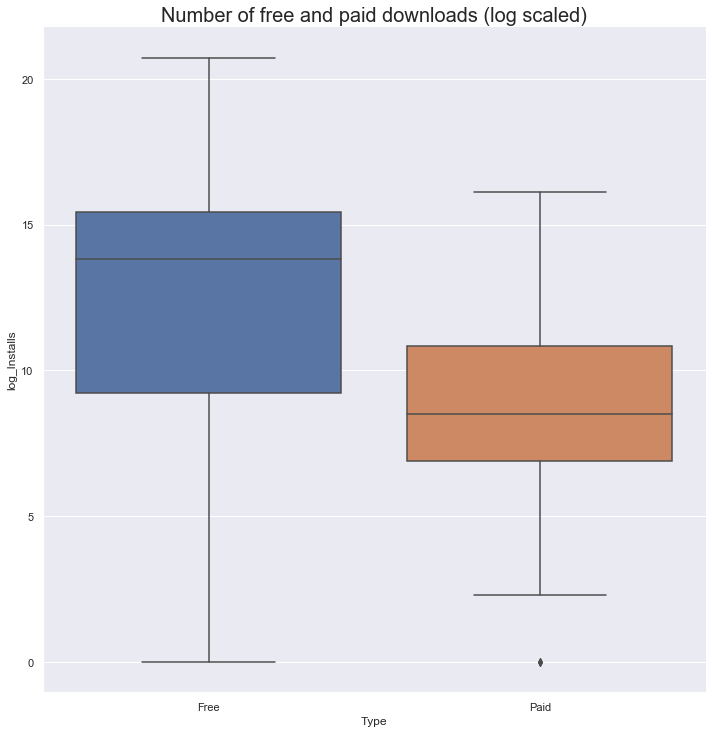

In [21]:
data['log_Installs'] = data.Installs.apply(lambda x: np.log(x))
sns.catplot(x ='Type', y= 'log_Installs', data=data, kind='box', height = 10, aspect=1)
plt.title('Number of free and paid downloads (log scaled)', fontsize=20)
plt.show()

- Naturally, users prefer to download free apps. But it's not so bad for those who makes paid apps

#### Correlation matrix

In [22]:
data.drop('log_Installs', axis=1, inplace=True)
pd.DataFrame(data.corr())

,Rating,Reviews,Size,Installs,Price
Rating,1.000000,0.068133,0.080308,0.051337,-0.021919
Reviews,0.068133,1.000000,0.129407,0.641605,-0.009824
Size,0.080308,0.129407,1.000000,0.081223,-0.026259
Installs,0.051337,0.641605,0.081223,1.000000,-0.011895
Price,-0.021919,-0.009824,-0.026259,-0.011895,1.000000


- A positive correlation of 68% exits between the number of reviews and the number of installs. This means, that users may load apps more likely if the apps are reviewed more often. And vice versa, the more downloads the more reviews apps have.

#### Brief look on users' reviews

In [23]:
reviews.dropna(inplace=True)

In [24]:
wc = WordCloud(background_color="white", max_words=200, colormap="Set2")
stop = stopwords.words('english') +['app']

In [25]:
def drop_stop(data):
    '''drops stopwords from a column'''
    data = data.apply(lambda x: ' '.join(x for x in str(x).split(' ') if x not in stop))
    
drop_stop(reviews.Translated_Review)

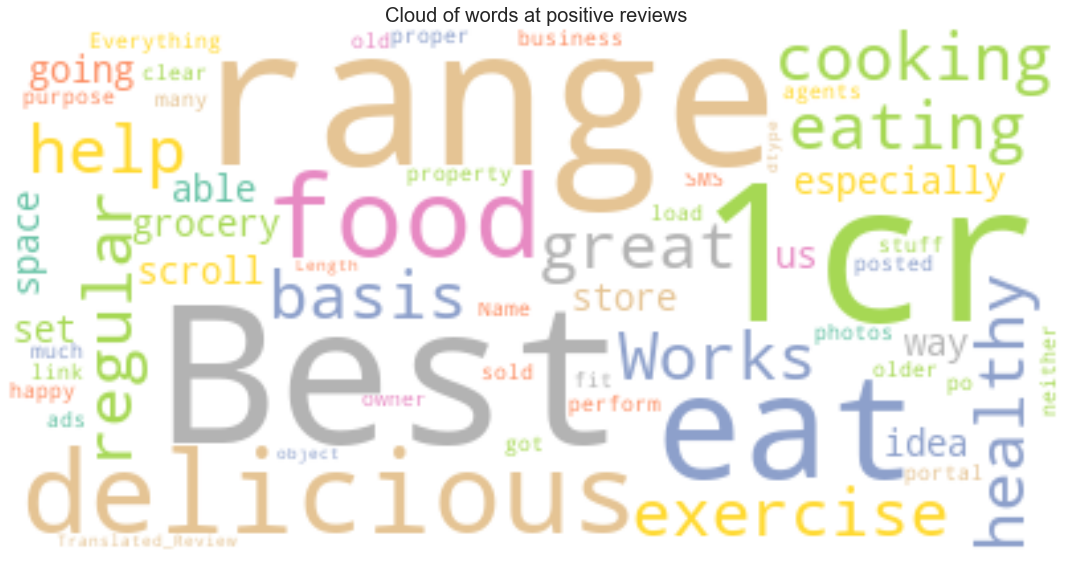

In [26]:
wc.generate(str(reviews.Translated_Review[reviews.Sentiment =='Positive']))
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Cloud of words at positive reviews', fontsize=20)
plt.tight_layout()
plt.show()

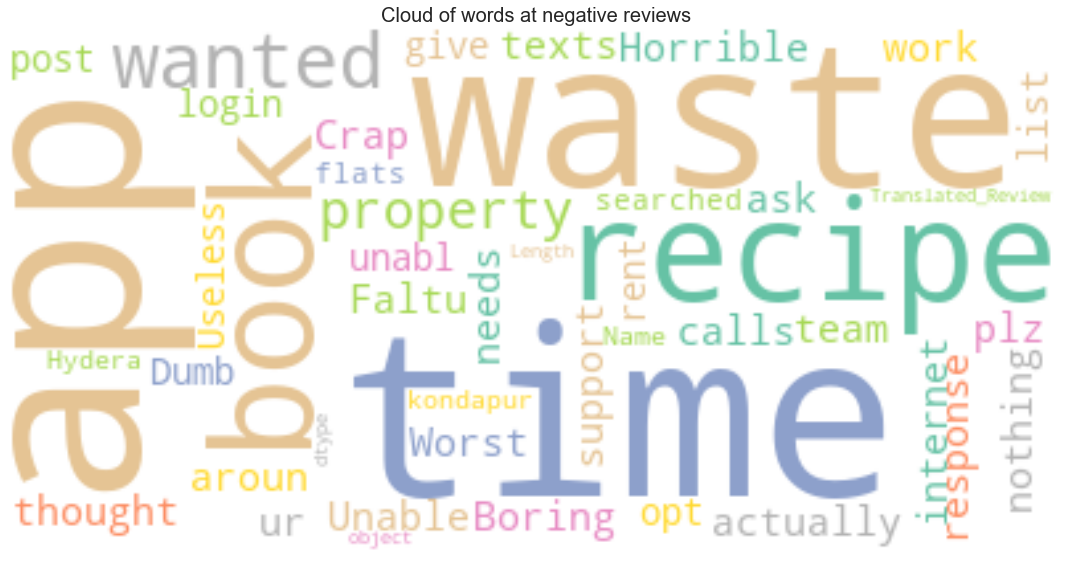

In [27]:
wc.generate(str(reviews.Translated_Review[reviews.Sentiment =='Negative']))
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Cloud of words at negative reviews', fontsize=20)
plt.tight_layout()
plt.show()

In [28]:
merged = data.merge(reviews, on = 'App', how ='inner')

In [29]:
pos =merged[merged.Sentiment =='Positive'].groupby('Category').sum().Reviews / merged.groupby('Category').sum().Reviews
neg =merged[merged.Sentiment =='Negative'].groupby('Category').sum().Reviews / merged.groupby('Category').sum().Reviews
neutral =merged[merged.Sentiment =='Neutral'].groupby('Category').sum().Reviews / merged.groupby('Category').sum().Reviews
review_share = pd.merge(pos, neg, on='Category', suffixes=('_Positive', '_Negative')).merge(neutral, on = 'Category')
review_share = review_share.rename(columns={'Reviews_Positive': 'Positive', 'Reviews_Negative': 'Negative', 'Reviews': 'Neutral'}).reset_index()

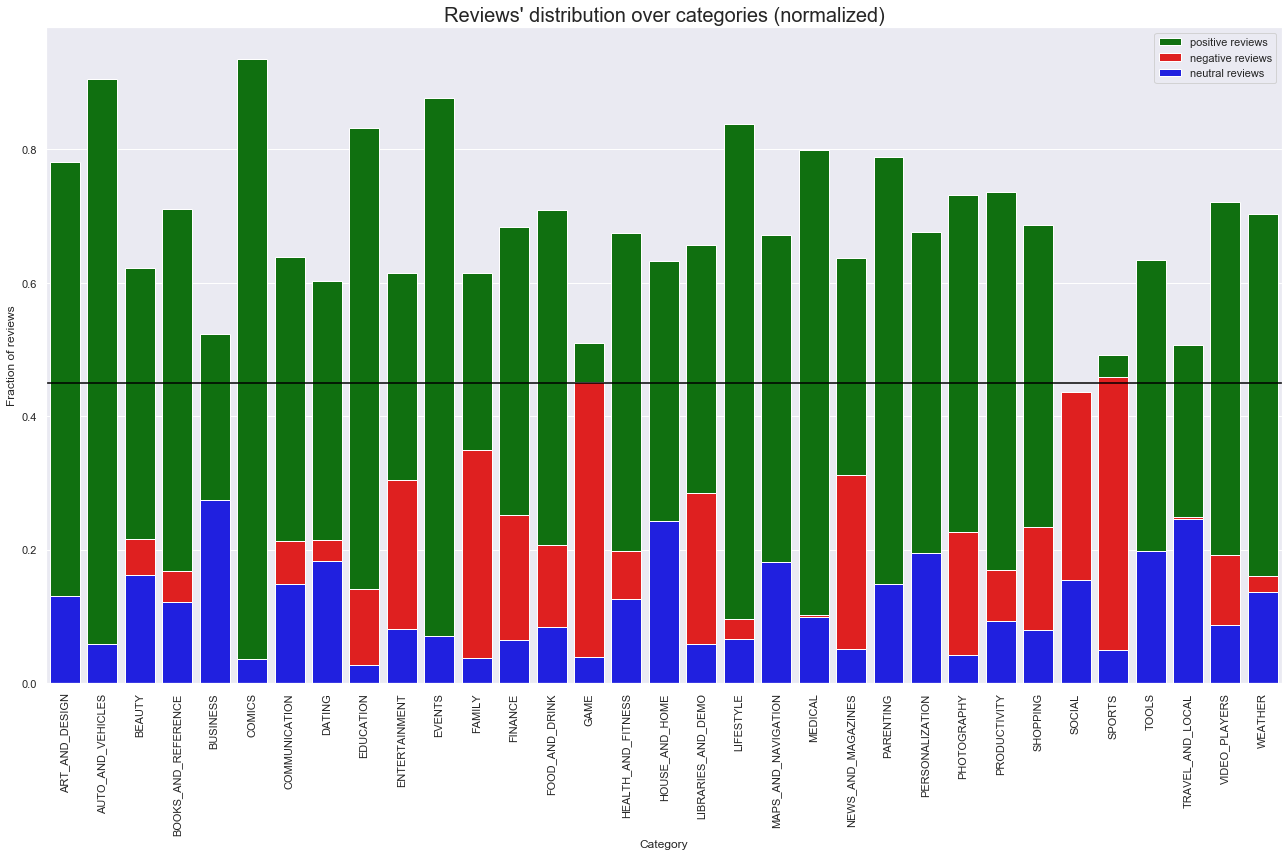

In [30]:
plt.figure(figsize=(18,12))
sns.barplot(review_share.Category, review_share.Positive, color='green', label ='positive reviews')
sns.barplot(review_share.Category, review_share.Negative, color='red', label='negative reviews')
sns.barplot(review_share.Category, review_share.Neutral, color='blue', label='neutral reviews')
plt.xticks(rotation=90)
plt.title('Reviews\' distribution over categories (normalized)', fontsize=20)
plt.tight_layout()
plt.axhline(y=0.45, color='black')
plt.ylabel('Fraction of reviews')
plt.legend()

plt.show()

- There are a lot of categories moth more than 80% of positive feedbacks.
- Surprisingly, Games, Social and Sports apps have about 45% of negative feedbacks.


## Building a predictive model for apps' rating <br>
There are 39 different ratings of apps in the dataset, from 1.2 to 5.0. This means we can meet the challenge both as multi-class classification or regression. I prefer regression for this particular problem because it is more important to determine an approximate rating with low error than try to predict classes. <br>
Firstly, I add info about sentiments to data to obtain more information about every particular app.<br>
For the baseline model, I'm not gonna use info about Apps' name, current versions of apps, Min required Android version, and date of an update because these columns seem hardly provide model a great deal of information:

In [31]:
data.drop(['App','Last Updated', 'Current Ver', 'Android Ver'], axis=1, inplace=True)

To choose an appropriate model good idea would clarify how apps' rating depends on features. I'm going to encode categorical features, transform data into 2 principal components to reduce dimension and plot it:

In [32]:
def encode_data(data):
    ''''returns 1 if Type is Paid, 0 if Free,
    splits Genres colums ionto two columns, then drops Genres'''
    data.Type = data.Type.apply(lambda x: 0 if x=='Free' else 1)
    data['Genre1'] = data.Genres.apply(lambda x: x.split(';')[0])
    data['Genre2'] = data.Genres.apply(lambda x: x.split(';')[1] if len(x.split(';')) > 1 else 'no')
    data.drop('Genres', axis=1, inplace=True)
    return data

encode_data(data)

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genre1,Genre2
0,ART_AND_DESIGN,4.1,159,19.00000,10000,0,0.0,Everyone,Art & Design,no
1,ART_AND_DESIGN,3.9,967,14.00000,500000,0,0.0,Everyone,Art & Design,Pretend Play
2,ART_AND_DESIGN,4.7,87510,8.70000,5000000,0,0.0,Everyone,Art & Design,no
3,ART_AND_DESIGN,4.5,215644,25.00000,50000000,0,0.0,Teen,Art & Design,no
4,ART_AND_DESIGN,4.3,967,2.80000,100000,0,0.0,Everyone,Art & Design,Creativity
...,...,...,...,...,...,...,...,...,...,...
10834,FAMILY,4.0,7,2.60000,500,0,0.0,Everyone,Education,no
10836,FAMILY,4.5,38,53.00000,5000,0,0.0,Everyone,Education,no
10837,FAMILY,5.0,4,3.60000,100,0,0.0,Everyone,Education,no
10839,BOOKS_AND_REFERENCE,4.5,114,22.97012,1000,0,0.0,Mature 17+,Books & Reference,no


In [33]:
cat_features =['Category', 'Content Rating', 'Genre1', 'Genre2']
encoder = ce.TargetEncoder(cols=cat_features)
encoder.fit(data[cat_features], data.Rating)
data = data.join(encoder.transform(data[cat_features]).add_suffix('_encoded'))
data.drop(cat_features, axis=1, inplace=True)
data

,Rating,Reviews,Size,Installs,Type,Price,Category_encoded,Content Rating_encoded,Genre1_encoded,Genre2_encoded
0,4.1,159,19.00000,10000,0,0.0,4.377049,4.186472,4.367187,4.186020
1,3.9,967,14.00000,500000,0,0.0,4.377049,4.186472,4.367187,4.246067
2,4.7,87510,8.70000,5000000,0,0.0,4.377049,4.186472,4.367187,4.186020
3,4.5,215644,25.00000,50000000,0,0.0,4.377049,4.233487,4.367187,4.186020
4,4.3,967,2.80000,100000,0,0.0,4.377049,4.186472,4.367187,4.311111
...,...,...,...,...,...,...,...,...,...,...
10834,4.0,7,2.60000,500,0,0.0,4.192383,4.186472,4.312433,4.186020
10836,4.5,38,53.00000,5000,0,0.0,4.192383,4.186472,4.312433,4.186020
10837,5.0,4,3.60000,100,0,0.0,4.192383,4.186472,4.312433,4.186020
10839,4.5,114,22.97012,1000,0,0.0,4.346067,4.123427,4.344444,4.186020


In [34]:
standardscale= StandardScaler()
x = StandardScaler().fit_transform(data)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalComponents
principal_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
reduced_data = principal_df.join(data[['Rating']])
reduced_data

,PC1,PC2,Rating
0,2.032769,-1.028196,4.1
1,2.141164,-1.187117,3.9
2,2.196418,-1.017829,4.7
3,2.900133,-0.512701,4.5
4,2.475689,-1.389910,4.3
...,...,...,...
9355,0.213862,-0.555519,4.1
9356,1.133319,-0.328378,4.6
9357,0.708402,-0.547568,4.6
9358,1.270819,-0.993550,3.8


Relationship between characteristics and rating of apps:


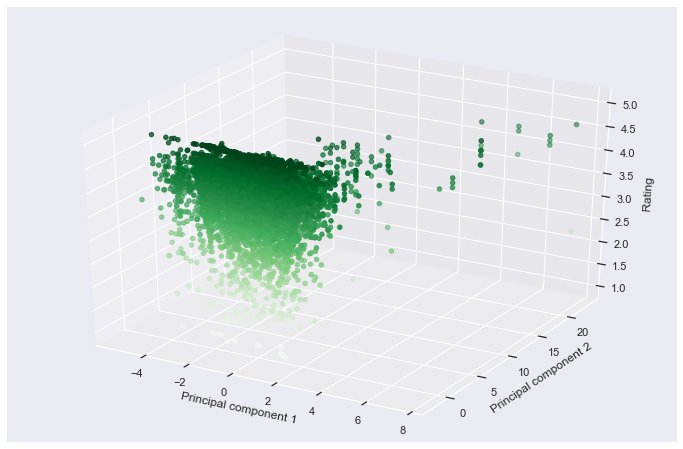

In [60]:
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, HTML
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
ax.set_zlabel('Rating')
ax.scatter3D(reduced_data.PC1, reduced_data.PC2, reduced_data.Rating, c=reduced_data.Rating, cmap='Greens')
print('Relationship between characteristics and rating of apps:')
plt.show()

The relationship between features and ratings doesn't lool like linear. That's why it's better to choose an algorithm that can find non-linear relationships, like Random Forest Regressor. Fortunately, this algorithm doesn't require any data preprocessing. 

In [61]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Rating', axis=1), data.Rating, test_size=0.3, shuffle=True)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6552, 9) (6552,) (2808, 9) (2808,)


In [70]:
%%time
scaler = MinMaxScaler()
rf = RandomForestRegressor(n_estimators=10000, max_features='sqrt', min_samples_leaf=1)
pipeline = Pipeline([('scaler', scaler), ('estimator', rf)])
rf.fit(X_train, y_train)

Wall time: 1min 55s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [71]:
new = pd.DataFrame(y_test).rename(columns={'Rating': 'Actual rating'})
new['Prediction'] = np.around(rf.predict(X_test), 1)
new

,Actual rating,Prediction
6820,4.8,3.9
4923,4.0,3.8
1677,4.7,4.4
4159,4.3,4.4
9534,4.2,3.8
...,...,...
6748,4.3,4.1
4075,3.9,4.0
1384,4.6,4.5
2302,4.6,3.9


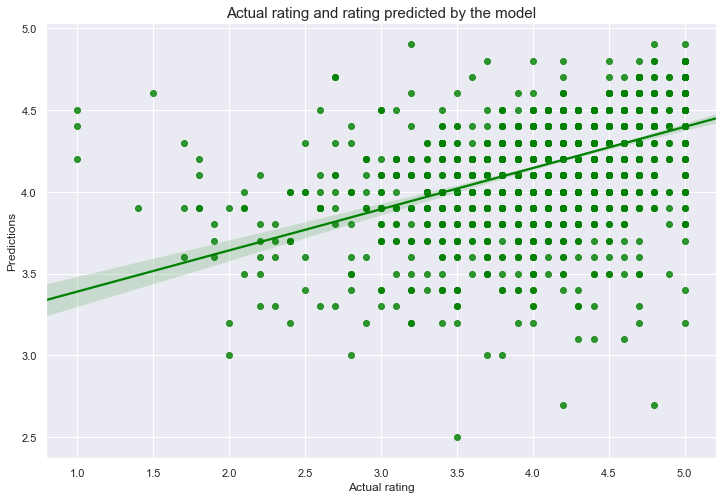

In [72]:
plt.figure(figsize=(12,8))
sns.regplot(new['Actual rating'], new['Prediction'], color='green')
plt.title('Actual rating and rating predicted by the model', fontsize=15)
plt.ylabel('Predictions')
plt.show()

In [73]:
print('Mean squared error equals:', round(mean_squared_error(new['Actual rating'], new['Prediction']),4))

Mean squared error equals: 0.2039


The algorithm found dependencies between different features and ratings of the apps and made good predictions with a mean squared error of about 0.2. It's interesting to see what features were the most important for Random Forest:

In [74]:
pd.DataFrame({'Feature': X_train.columns, 'Importance': np.around(rf.feature_importances_,4) }).sort_values('Importance', ascending=False)

,Feature,Importance
0,Reviews,0.3307
1,Size,0.2657
2,Installs,0.1305
7,Genre1_encoded,0.1130
5,Category_encoded,0.0936
6,Content Rating_encoded,0.0291
4,Price,0.0227
3,Type,0.0075
8,Genre2_encoded,0.0072


# Conclision:<br>
- Average rating of apps in Google Play Store is 4.19
- Big amount of Reviews is extremely important for a high rating. Users tend to download a given app more and grade it higher if it has been reviewed by a large number of people
- Most of the top-rated apps are optimally sized between ~2MB to ~30MB - neither too light nor too heavy. And size of an app it is another characteristic that strongly influences rating.
- Comics, Auto, and Vehicle as well as Events, Lifestyle and Educations apps receive more than 80% positive reviews. Surprisingly, Games, Social and Sports apps have about 45% of negative feedback.
- Type of an app (Free or Paid) doesn't influence grades from users. 